Hello! Welcome! I would try to cover here in general as possible my thought and routes I took that led me to the prediction! I would be very glad to 
elaborate more!

In the whole git folder I made an interactive python that runs from the main.py.


Here we'll make it more straightforward

Let's upload some of the basic packages we would use

In [32]:
import sqlite3
import pandas as pd

from sklearn.model_selection import train_test_split
import pickle
from functools import reduce
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import numpy as np


I've uploaded the database into the current folder for simplicity

Here you can see that we are getting the two tables of the database: the homes and the motion). We filter out all the homes that have data of motion , otherwise we can really predict anything about them!
Note that in the last row, we are merging all the tables together for the beginning

In [11]:
    # loading raw data
    conn = sqlite3.connect('data.db')

    # Loading both of the tables
    homes_y = pd.read_sql_query("""   
    SELECT * 
    FROM homes 
    WHERE id IN (SELECT home_id FROM motion);
    """, conn)
    motion = pd.read_sql_query("SELECT * FROM motion", conn)
    conn.close()


    all_data_table = pd.merge(homes_y, motion, left_on='id', right_on='home_id', suffixes=('_home', '_motion')).drop(
        columns=['home_id'])




No we are going to the next function. Here we are perfoming two steps. First is the preperation of the features we are going to use for the final prediction, while in the 2nd step we would split the data into train and test sets. 
Note: I've chosen only 3 specific features, and that came after an exstensive analysis that took the majority of my time - I tried to find good features that predict together the best, if a house has multiple occupancy or not. These were the best I could find. Further on about the different features I've engineered from the data and generally my approached - in the appendix in the end.

But before we do that, we build 2 distinct functions that would do the analysis on the data, and then we would use these functions.

Below the two functions:
In the first one we are counting the mean hour of movements per house, and its std .
Also we count the amount of movements per house from all the data that was gathered.


In the second function we look only at the night time and close to it, since I believe that movement at night is way more
likely because of an occupnat and not a visitor. We count the number of changes between rooms at that time. I assume that
if there are more than one person living there, then in general there should be more chancges in between the rooms,
since such behavious is more likely to be explained by more than one person

In [14]:
def proc_1(table):
    # Table_1 features:
    # motion_count = count of motions overall, between houses
    # hour_mean = mean of the hours of movements
    # hour_std = the std of the mean of the hours of the movements
    table['hour'] = table['datetime'].dt.hour
    features_1 = table.groupby('id_home').agg({
        'id_motion': 'count',  # Number of motion events
        'hour': ['mean', 'std'],  # Mean and standard deviation of the hour of events
    }).reset_index()
    features_1.columns = ['id_home', 'motion_count', 'hour_mean', 'hour_std']
    table_ready = features_1.copy()

    return table_ready


def proc_2(table):
    # Table_2 features:
    # Change count between room types at night

    table['date'] = table['datetime'].dt.date
    # filtering out only the night hours
    mask = (table['hour'] >= 20) | (table['hour'] < 10)
    filtered_df = table[mask]
    filtered_df_sorted = (filtered_df.sort_values(['id_home', 'datetime'])).reset_index()
    # counting the amount of transitions between rooms
    filtered_df_sorted['match'] = filtered_df_sorted.location != filtered_df_sorted.location.shift()
    filtered_df_sorted = (filtered_df_sorted.sort_values(['id_home', 'datetime'])).groupby(
        ['id_home', 'multiple_occupancy']).agg({'match': 'count'}).reset_index()
    table_ready = filtered_df_sorted.copy()

    return table_ready


In [16]:
    all_data_table['datetime'] = pd.to_datetime(all_data_table['datetime'])

    ### Step 1: Process and prepare features for train-test split:

    functions_to_proc = [proc_1, proc_2]
    tables_to_merge = []
    for fun_to_proc in functions_to_proc:
        tables_to_merge.append(fun_to_proc(all_data_table))

    full_data_pre_model = reduce(lambda df1, df2: pd.merge(df1, df2, on='id_home'), tables_to_merge)

    ### Step 2: Choose features and Train Test Split

    X = full_data_pre_model[['motion_count', 'match', 'hour_mean']]
    y = full_data_pre_model['multiple_occupancy']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Here you can see implementation of random forest on 5-fold, and see that the average accuracy is 70% percent

In [36]:

    clf = RandomForestClassifier(random_state=42, n_estimators = 20)
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'5-Fold Cross-Validation Scores: {cv_scores}')
    print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores)}')

    # Compute the confusion matrix for each fold
    conf_matrices = []
    kf = KFold(n_splits=5)

    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])

    X = X.to_numpy()
    y = y.to_numpy()

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(X_train_fold, y_train_fold)
        y_pred_fold = clf.predict(X_test_fold)
        conf_matrices.append(confusion_matrix(y_test_fold, y_pred_fold))

    # Compute the mean confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    print('Mean Confusion Matrix (5-fold):')
    print(mean_conf_matrix)

5-Fold Cross-Validation Scores: [0.75  0.375 0.875 0.75  0.75 ]
Mean Cross-Validation Accuracy: 0.7
Mean Confusion Matrix (5-fold):
[[0.8 2.8]
 [2.  4.4]]


Other implementations can be see further on in the git repository

# Appendix and my stream of thoughts:

As someone who used to work on medical data where you have a very low amount of data points/examples (<100 images/scans) in relation to the amount of features (more than 10^6 features) I know very well how much of a serious problem it is - in cases like that each features has too little of releavance to the final output, and training on such data can lead us to severe overfitting.

In cases like this what I would do , is try to diminish the amounth of features as much as possible.
There is a rule of thumb that the amount of features should be around 10 times lower than the amount of training examples to give good prediction. Thus we can say that we are looking around 2-5 features that we need to choose.


Before going into features engineering, I tried to squeeze any possible alternative, fearing that feature engineering might lose precious information that exsists in the original data. 

I tried to look and train the data on simplified versions of complex algorithms, believeing that we can look at the distributions of apperance of different rooms in the data, in different times, the same way that we can look at distributiobs that are coming from more than one source or not (and thus causing the overlly noisy set of distributions) but without luck, since again, the amount of data was too low. Algrithms I used were: Nerual Network (with fewer neurons), LSTM, GRU, RNN, 1D-CNN , CRF ,HMM , PCA etc., but without any surpsise they all led of course to over-fitting or under-fitting.

The most promising thing to me from the very beginning was to find general features and use them.




What I would do is to filter the whole data by different features that came up to my mind and saw how the distribution of both classes changes when we are sorting the data by these features.






One of the main ideas was that people who are occupying a house usually tend to be more the cause for signaling in the house than in other time (in which there is more probability for visitors to come).



I looked at several features at regarding the night time:

1. Count of movements only in the bedroom per house (no 2 bedrooms in one house ever found)
2. Average count of movements only in the bedroom per house, between different dates
3. Changes in between rooms at night - overall count and average in between days.

I also looked at other things:

4. Distributions of hours between houses
5. Overall frequency of changes between rooms - count and average in between days
6. Overall count of movements per house
7. Average count of movements per house per room, and in between the rooms
8. Counts of visits in specific rooms like bathrooms

(Also tried to divide features in between each other when it looked reasonable. For example - no{1} above divided by the overall count in the house (normalisation))

Beyond that I also tried to take several features at once and apply PCA and mRMR algorithms, to filter the most relevant features.

ALL of these, didn't help, and thus I was left to take the features that were the most promising. I chose these features by trying to plot training set group on x and y axises and colouring them in two different colours representing each class. I knew that 2 features that would sepereate the classes better, would be used further on for the ML algorithm.

Below some examples:


Motion count per house and the number of room changes overall per house. You can see that these 2 features together are very unlikely to distinguish between two classes

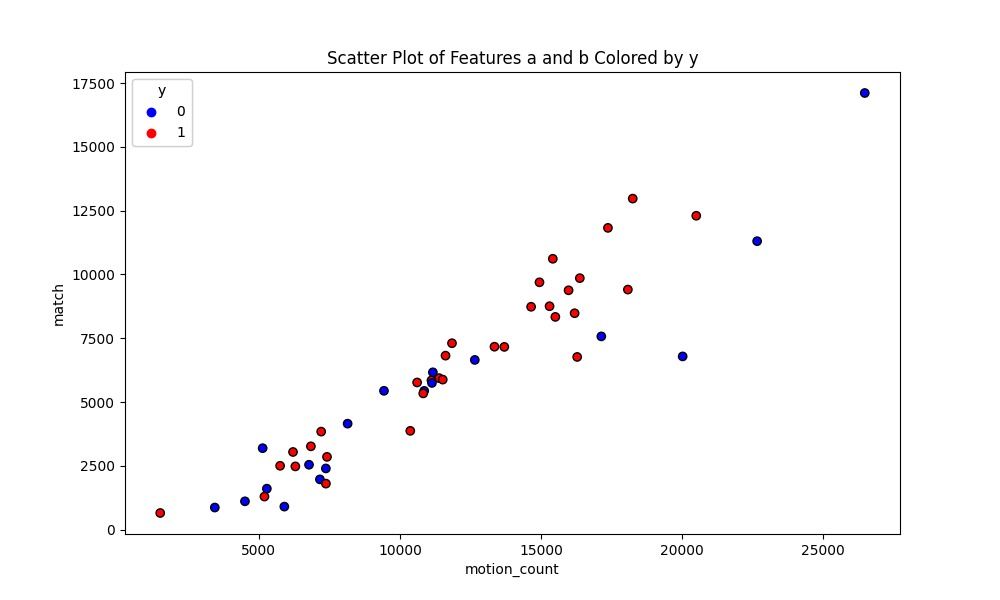


Motion count per house devided by the number of days where recording in the house was accuring. You can see here as well that it doesn't yield the best seperator

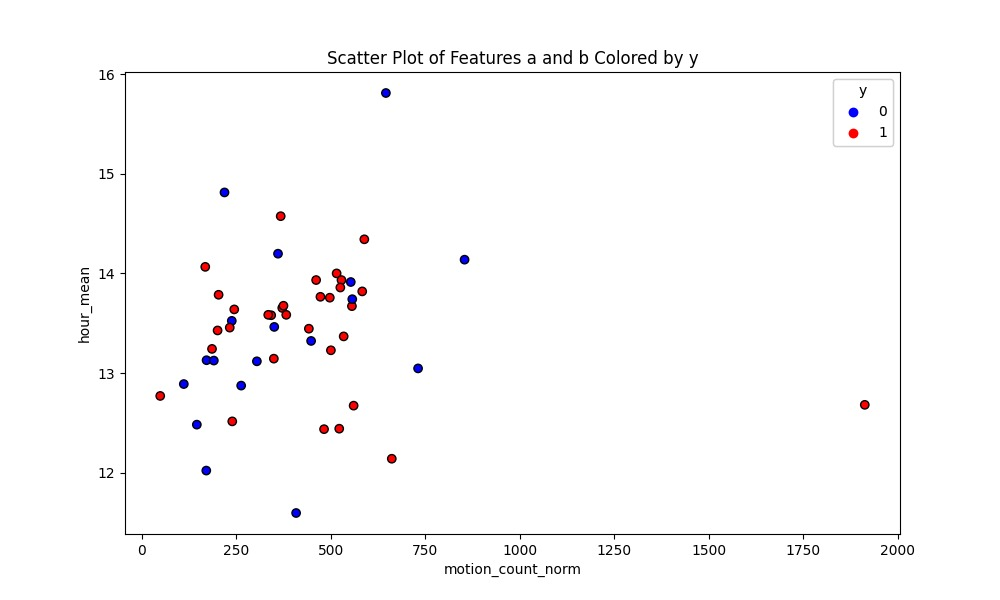

Motion count overall vs mean hour of movements in the house. Slightly better than the other ones

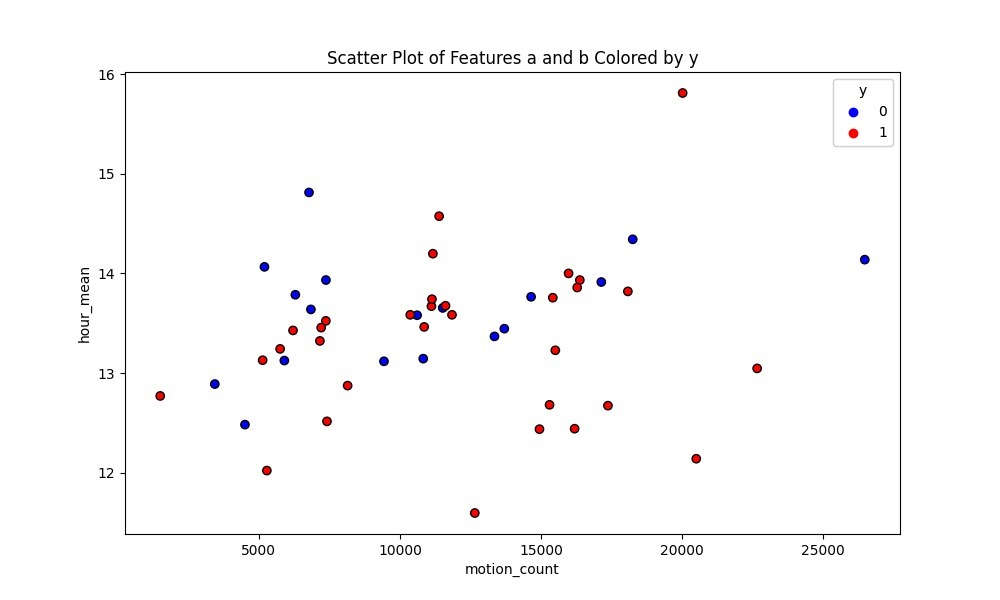


Motion count and the count of changes between rooms in generall

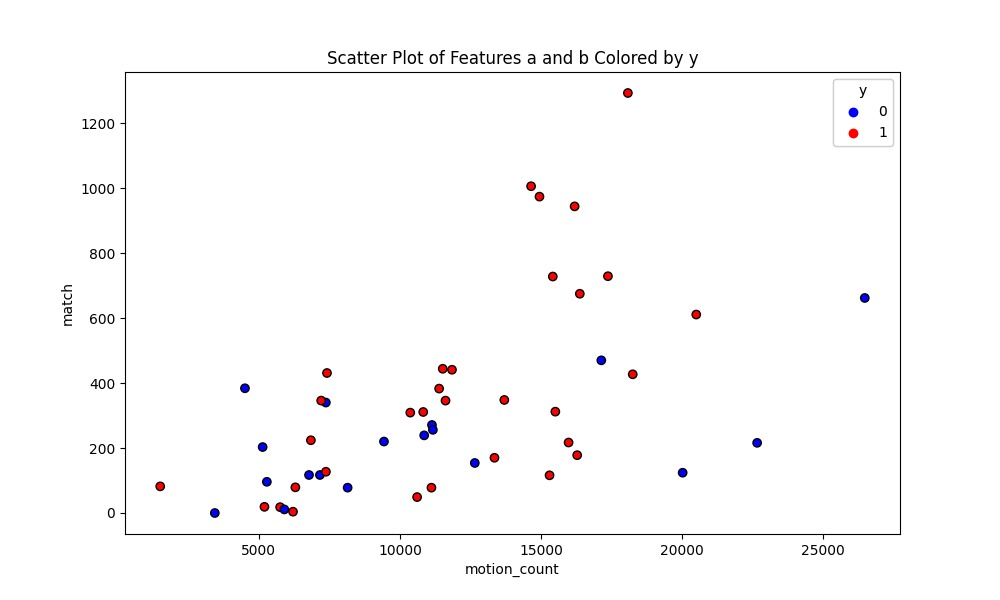

After all of this analysises, I decided to give my trust to decision trees, since I believe that this type of features-combination is a 
riddle that requier a set of question-rules rather than set of functions (for example, random forest can ask, after looking at the two features in the last previous graph: what is the number of counts and number of room changes? and if they are less then 140,000 and 420 respecitvaly, than we can look at some other features , since the data in this areas is way too similar)

Looking at all the graphs generated, I decided that the last two presented here were the most promising, and thus chose their features to represent the classes, and thus used them in the ML algorthims.
In github I've uploaded only results for Random Forest and Decision Trees since for other ML algorithms (like linear regression and SVM) the results (mean average of accuracy over 5 folds) where around 60%.

So as you can see, 'motion_count', 'match', 'hour_mean' where the chosen features and using them I was able to reach 70% accuracy after 5 fold algori